# Project Notebook

## 25.12.2019
### Data Processing

- Created a custom data transformer to transform Shapefile annotations of dataset into COCO format for compatible use with Detectron2.

- There is misalignement in the dataset images and corresponding annotations. For now the conversion from GIS latitude and longitude coordinates to pixel coordinates has been hardcoded, but should be dealt with to correct alignment.

- Segment classification has been preserved, but can be modified to restrict segmentation to a single class (i.e. tree) initially as apposed to tree types.

## 02.01.2019
### Data Processing

- The misalignment has now been corrected for, by dynamically using GIS libraries.
- This custom data loader also supports multiple datasets (all within a main dataset directory), but for single orthographic images.
- These single annotated orthographic images still need to be cut up into fixed sized samples.

In [1]:
# define path to visualize COCO transformed dataset
dataset_path = "/Users/Ro/Google Drive/UBC_EngCapstone/sample_data/CPT2a-n"

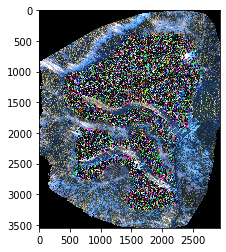

In [4]:
import detectron2
from detectron2.utils.visualizer import Visualizer
import cv2
from data.register_shapefile_datatset import shapefile_to_coco_dict
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt

classes, dataset_dicts = shapefile_to_coco_dict(dataset_path)
img = cv2.imread(dataset_path+'/CPT2a-n_ortho-resample.tif')
visualizer = Visualizer(img[:, :, :], metadata=MetadataCatalog.get("CPT2a-n"), scale=1)
vis = visualizer.draw_dataset_dict(dataset_dicts[0])
plt.imshow(vis.get_image()[:, :, ::-1])
plt.show()

## 03.01.2019
### Training

Run 'dummy' training on some annotated orthos to test the pipline.

In [4]:
# Register all Shapefile datasets into COCO for Detectrons

import os
import detectron2
from data.register_shapefile_datatset import shapefile_to_coco_dict
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_path = "/Users/Ro/Google Drive/UBC_EngCapstone/sample_data/"

datasets = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d)) and os.path.isdir(os.path.join(dataset_path, d + '/Segments'))]
# for dataset in datasets:
dataset = datasets[0]
if dataset not in DatasetCatalog.list():
    classes, dataset_dicts = shapefile_to_coco_dict(os.path.join(dataset_path, dataset))
    DatasetCatalog.register(dataset, lambda : dataset_dicts)
    MetadataCatalog.get(dataset).set(thing_classes=classes)

CPT2a-n


In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
# Device -> CPU for now
cfg.MODEL.DEVICE = 'cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (dataset,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1
# cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # Let training initialize from model zoo
# Downloaded manually due to SSL certification error
cfg.MODEL.WEIGHTS = os.path.realpath('model_zoo/model_final_f10217.pkl')
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (tree)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Config '/Users/Ro/Documents/github/drone-tree-id/lib/detectron2_repo/detectron2/model_zoo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


OrderedDict()

In [8]:
# import torchvision
%load_ext tensorboard
%tensorboard --logdir output

In [26]:
from detectron2.engine import DefaultPredictor
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = (dataset, )
predictor = DefaultPredictor(cfg)

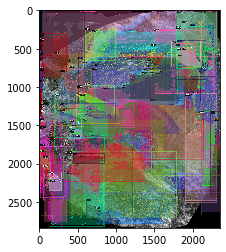

In [27]:
from detectron2.utils.visualizer import ColorMode, Visualizer
import matplotlib.pyplot as plt
from data.register_shapefile_datatset import shapefile_to_coco_dict
import cv2

dataset_path = "/Users/Ro/Google Drive/UBC_EngCapstone/sample_data/CPT2a-n"
_, dataset_dicts = shapefile_to_coco_dict(dataset_path)
im = cv2.imread(dataset_dicts[0]["file_name"])
outputs = predictor(im)
v = Visualizer(im[:, :, :],
               metadata=MetadataCatalog.get("CPT2a-n"), 
               scale=0.8, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])
plt.show()